<a href="https://colab.research.google.com/github/ChirayuSalgarkar/SafeDiffuseTraj/blob/main/Diffusion_Trajectory_Planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Tuple, Optional

class DiffusionTrajectoryPlanner:
    def __init__(
        self,
        state_size: int = 4,  # (px, py, vx, vy)
        action_size: int = 2,  # (ax, ay)
        horizon: int = 100,
        num_diffusion_steps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.horizon = horizon
        self.num_diffusion_steps = num_diffusion_steps

        # Set up diffusion parameters
        self.betas = torch.linspace(beta_start, beta_end, num_diffusion_steps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # Neural network for denoising
        self.denoiser = TrajectoryDenoiser(
            state_size=state_size,
            action_size=action_size,
            hidden_size=128
        )

    def sample_trajectory(
        self,
        start_state: torch.Tensor,  # [state_size]
        goal_state: torch.Tensor,   # [state_size]
        obstacles: List[Tuple[float, float, float]],  # [(x, y, radius), ...]
        safety_margin: float = 0.1
    ) -> torch.Tensor:  # [horizon, state_size + action_size]
        """Generate a safe trajectory from start to goal state avoiding obstacles."""

        # Initialize from Gaussian noise
        trajectory = torch.randn(self.horizon, self.state_size + self.action_size)

        # Set start state
        trajectory[0, :self.state_size] = start_state

        # Reverse diffusion process
        for t in reversed(range(self.num_diffusion_steps)):
            # Get current timestep parameters
            alpha_t = self.alphas_cumprod[t]
            alpha_t_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)

            # 1. Predict noise using denoising network
            noise_pred = self.denoiser(trajectory, torch.tensor([t]))

            # 2. Compute reachability gradient
            reach_grad = self.compute_reachability_gradient(
                trajectory[:, :self.state_size],
                obstacles,
                safety_margin
            )

            # 3. Update trajectory with combined guidance
            trajectory = self.update_step(
                trajectory,
                noise_pred,
                reach_grad,
                alpha_t,
                alpha_t_prev,
                t
            )

            # 4. Project to satisfy dynamics constraints
            trajectory = self.project_dynamics(trajectory)

            # 5. Fix boundary conditions
            trajectory[0, :self.state_size] = start_state
            trajectory[-1, :self.state_size] = goal_state

        return trajectory

    def compute_reachability_gradient(
        self,
        states: torch.Tensor,  # [horizon, state_size]
        obstacles: List[Tuple[float, float, float]],
        safety_margin: float
    ) -> torch.Tensor:
        """Compute gradient to push trajectory away from obstacles."""
        grad = torch.zeros_like(states)

        for t in range(self.horizon):
            pos = states[t, :2]  # x, y position

            for obs_x, obs_y, obs_radius in obstacles:
                obs_pos = torch.tensor([obs_x, obs_y])
                dist = torch.norm(pos - obs_pos)

                # If we're too close to obstacle, push away
                if dist < obs_radius + safety_margin:
                    direction = (pos - obs_pos) / (dist + 1e-6)
                    grad[t, :2] += direction * (obs_radius + safety_margin - dist)

        return grad

    def update_step(
        self,
        trajectory: torch.Tensor,
        noise_pred: torch.Tensor,
        reach_grad: torch.Tensor,
        alpha_t: torch.Tensor,
        alpha_t_prev: torch.Tensor,
        timestep: int,
        reach_weight: float = 0.1
    ) -> torch.Tensor:
        """Combine diffusion update with reachability gradient."""
        # Standard diffusion update
        noise_coef = (1 - alpha_t_prev) / (1 - alpha_t) * self.betas[timestep]
        traj_update = (trajectory - noise_coef * noise_pred) / torch.sqrt(alpha_t_prev)

        # Add reachability guidance
        grad_scale = reach_weight * torch.sqrt(1 - alpha_t)
        traj_update[:, :self.state_size] += grad_scale * reach_grad

        return traj_update

    def project_dynamics(self, trajectory: torch.Tensor) -> torch.Tensor:
        """Project trajectory to satisfy system dynamics constraints."""
        states = trajectory[:, :self.state_size]
        actions = trajectory[:, self.state_size:]

        for t in range(self.horizon - 1):
            # Update position: p_{t+1} = p_t + v_t
            states[t+1, :2] = states[t, :2] + states[t, 2:4]

            # Update velocity: v_{t+1} = v_t + a_t
            states[t+1, 2:4] = states[t, 2:4] + actions[t]

            # Project actions to unit disk
            action_norm = torch.norm(actions[t])
            if action_norm > 1:
                actions[t] = actions[t] / action_norm

        return torch.cat([states, actions], dim=1)

class TrajectoryDenoiser(nn.Module):
    """Neural network that predicts noise in the trajectory."""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super().__init__()

        traj_size = state_size + action_size

        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        self.net = nn.Sequential(
            nn.Linear(traj_size + hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, traj_size)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Trajectory [horizon, state_size + action_size]
            t: Diffusion timestep [1]
        Returns:
            Predicted noise in trajectory
        """
        t_emb = self.time_embed(t.unsqueeze(-1).float())
        t_emb = t_emb.expand(x.shape[0], -1)

        x_flat = x.view(x.shape[0], -1)
        h = torch.cat([x_flat, t_emb], dim=-1)

        return self.net(h)

# Example usage
def test_planner():
    # Initialize planner
    planner = DiffusionTrajectoryPlanner()

    # Define problem
    start_state = torch.tensor([0.0, 0.0, 0.0, 0.0])  # Initial position and velocity
    goal_state = torch.tensor([1.0, 1.0, 0.0, 0.0])   # Target position and velocity
    obstacles = [(0.5, 0.5, 0.1)]  # List of (x, y, radius)

    # Generate trajectory
    trajectory = planner.sample_trajectory(start_state, goal_state, obstacles)
    return trajectory

if __name__ == "__main__":
    trajectory = test_planner()
    print("Trajectory shape:", trajectory.shape)
    print("Start position:", trajectory[0, :2])
    print("End position:", trajectory[-1, :2])

Trajectory shape: torch.Size([100, 6])
Start position: tensor([0., 0.], grad_fn=<SliceBackward0>)
End position: tensor([1., 1.], grad_fn=<SliceBackward0>)


In [ ]:
# Initialize planner
planner = DiffusionTrajectoryPlanner()

# Define problem
start_state = torch.tensor([0.0, 0.0, 0.0, 0.0])  # Initial position and velocity
goal_state = torch.tensor([1.0, 1.0, 0.0, 0.0])   # Target position and velocity
obstacles = [(0.5, 0.5, 0.1)]  # List of (x, y, radius)

# Generate trajectory
trajectory = planner.sample_trajectory(start_state, goal_state, obstacles)

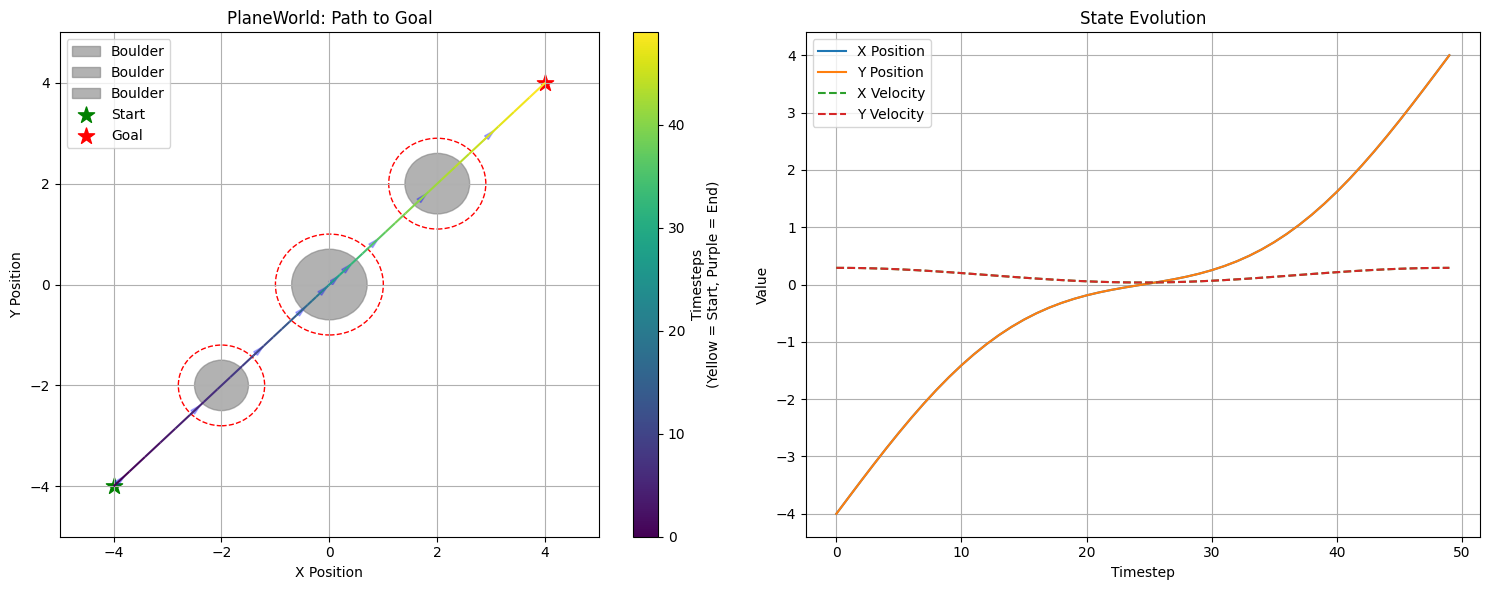

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

class PlaneWorld:
    def __init__(self):
        # Define world boundaries
        self.x_bounds = (-5, 5)
        self.y_bounds = (-5, 5)

        # Define obstacles (boulders)
        self.boulders = [
            {'pos': (-2, -2), 'radius': 0.5},
            {'pos': (0, 0), 'radius': 0.7},    # Center boulder
            {'pos': (2, 2), 'radius': 0.6}
        ]

    def check_collision(self, pos1, pos2):
        """Check if line segment between pos1 and pos2 intersects any boulder"""
        for boulder in self.boulders:
            center = np.array(boulder['pos'])
            radius = boulder['radius']

            # Vector from pos1 to pos2
            d = pos2 - pos1
            # Vector from pos1 to circle center
            f = pos1 - center

            a = np.dot(d, d)
            b = 2 * np.dot(f, d)
            c = np.dot(f, f) - radius**2

            discriminant = b**2 - 4*a*c
            if discriminant >= 0:
                t1 = (-b - np.sqrt(discriminant))/(2*a)
                t2 = (-b + np.sqrt(discriminant))/(2*a)
                if 0 <= t1 <= 1 or 0 <= t2 <= 1:
                    return True

        return False

def visualize_plane_world(
    world: PlaneWorld,
    trajectory: torch.Tensor,
    start_state: torch.Tensor,
    goal_state: torch.Tensor
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Extract positions and velocities
    positions = trajectory[:, :2].detach().numpy()
    velocities = trajectory[:, 2:4].detach().numpy()

    # Left Plot: Spatial Trajectory
    ax1.set_title("PlaneWorld: Path to Goal")

    # Plot world boundaries
    ax1.set_xlim(world.x_bounds)
    ax1.set_ylim(world.y_bounds)

    # Plot boulders
    for boulder in world.boulders:
        # Main boulder
        circle = Circle(boulder['pos'], boulder['radius'],
                       fill=True, alpha=0.6, color='gray', label='Boulder')
        ax1.add_patch(circle)
        # Safety margin
        safety = Circle(boulder['pos'], boulder['radius'] + 0.3,
                       fill=False, linestyle='--', color='red')
        ax1.add_patch(safety)

    # Plot trajectory
    points = positions.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(segments))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.linspace(0, len(segments), len(segments)))
    line = ax1.add_collection(lc)
    cbar = fig.colorbar(line, ax=ax1)
    cbar.set_label('Timesteps\n(Yellow = Start, Purple = End)')

    # Plot start and goal
    ax1.scatter(start_state[0], start_state[1], color='green', s=150,
                label='Start', marker='*')
    ax1.scatter(goal_state[0], goal_state[1], color='red', s=150,
                label='Goal', marker='*')

    # Add velocity arrows
    for i in range(0, len(positions), 5):
        ax1.arrow(positions[i, 0], positions[i, 1],
                 velocities[i, 0] * 0.2, velocities[i, 1] * 0.2,
                 head_width=0.1, head_length=0.2, fc='blue', ec='blue',
                 alpha=0.3)

    ax1.set_xlabel("X Position")
    ax1.set_ylabel("Y Position")
    ax1.legend()
    ax1.grid(True)

    # Right Plot: State Evolution
    ax2.set_title("State Evolution")
    time = np.arange(len(trajectory))

    ax2.plot(time, positions[:, 0], label='X Position')
    ax2.plot(time, positions[:, 1], label='Y Position')
    ax2.plot(time, velocities[:, 0], label='X Velocity', linestyle='--')
    ax2.plot(time, velocities[:, 1], label='Y Velocity', linestyle='--')

    ax2.set_xlabel("Timestep")
    ax2.set_ylabel("Value")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Test the visualization
if __name__ == "__main__":
    world = PlaneWorld()

    # Define start and goal states farther apart
    start_state = torch.tensor([-4., -4., 0., 0.])  # Start at (-4,-4) with zero velocity
    goal_state = torch.tensor([4., 4., 0., 0.])     # Goal at (4,4) with zero velocity

    # For testing, generate a simple curved trajectory
    t = np.linspace(0, 1, 50)
    positions = np.stack([
        -4 + 8*t + np.sin(2*np.pi*t),  # x goes from -4 to 4 with sine wave
        -4 + 8*t + np.sin(2*np.pi*t)   # y goes from -4 to 4 with sine wave
    ], axis=1)
    velocities = np.gradient(positions, axis=0)
    trajectory = torch.tensor(np.concatenate([positions, velocities], axis=1))

    visualize_plane_world(world, trajectory, start_state, goal_state)

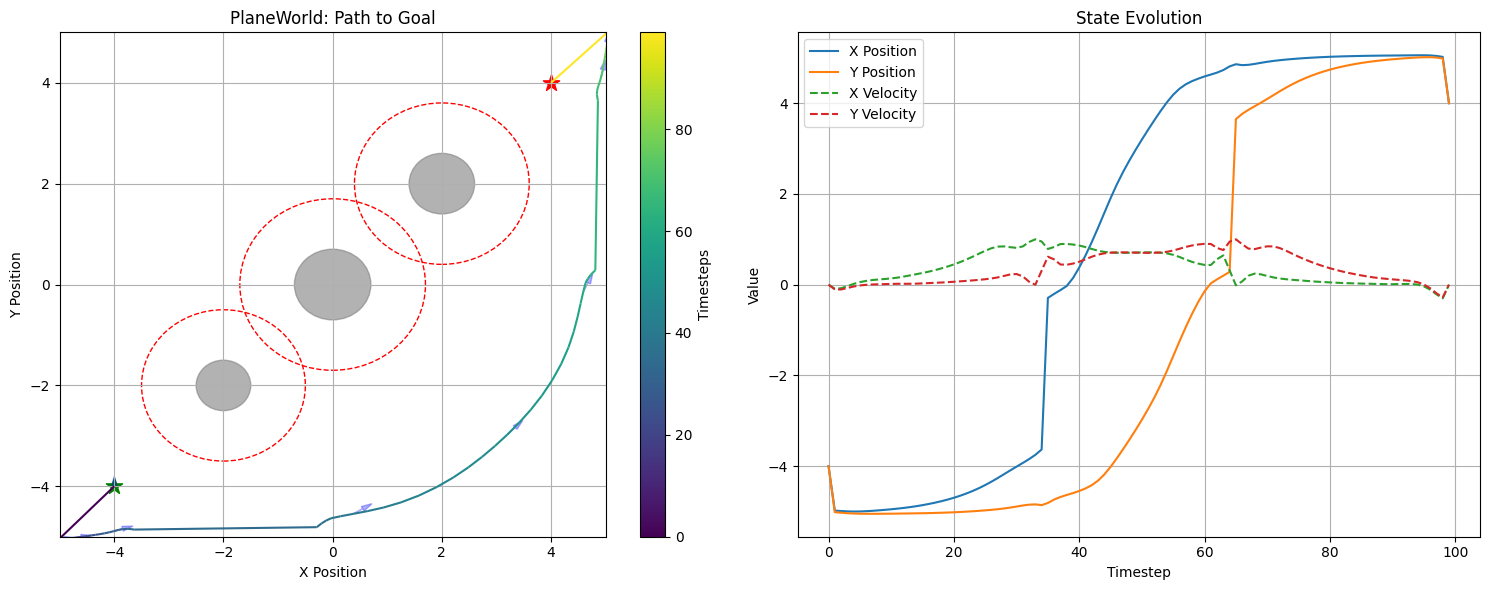

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

class PlaneWorld:
    def __init__(self):
        self.x_bounds = (-5, 5)
        self.y_bounds = (-5, 5)

        self.boulders = [
            {'pos': (-2, -2), 'radius': 0.5},
            {'pos': (0, 0), 'radius': 0.7},
            {'pos': (2, 2), 'radius': 0.6}
        ]

    def compute_safety_cost(self, pos):
        """Compute safety cost with stronger penalties for being close to boulders"""
        total_cost = 0
        safety_margin = 1.0  # Increased safety margin

        for boulder in self.boulders:
            center = torch.tensor(boulder['pos'])
            radius = boulder['radius']
            dist = torch.norm(pos - center)

            # Exponential cost that grows quickly as we get closer to the boulder
            safety_dist = dist - (radius + safety_margin)
            cost = torch.exp(-2 * safety_dist)
            total_cost += cost

        return total_cost

class DiffusionPlanner:
    def __init__(
        self,
        world: PlaneWorld,
        horizon: int = 100,
        num_diffusion_steps: int = 500  # Increased number of steps
    ):
        self.world = world
        self.horizon = horizon
        self.num_diffusion_steps = num_diffusion_steps

    def generate_trajectory(
        self,
        start_state: torch.Tensor,
        goal_state: torch.Tensor
    ) -> torch.Tensor:
        # Initialize trajectory with sigmoid interpolation for better initial guess
        t = torch.linspace(-6, 6, self.horizon)
        sigmoid = torch.sigmoid(t)
        sigmoid = sigmoid.unsqueeze(1)

        # Create initial trajectory that curves around the center
        offset = torch.tensor([1.0, -1.0, 0.0, 0.0])  # Offset to avoid center
        trajectory = (1 - sigmoid) * start_state + sigmoid * goal_state
        trajectory[:, :2] += 2 * torch.sin(np.pi * sigmoid) * offset[:2]  # Add curve

        trajectory = trajectory.detach().requires_grad_(True)
        optimizer = torch.optim.Adam([trajectory], lr=0.01)

        # Learning rate scheduler for better convergence
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.num_diffusion_steps)

        for step in range(self.num_diffusion_steps):
            optimizer.zero_grad()

            # 1. Path smoothness loss
            smoothness_loss = torch.norm(trajectory[1:] - trajectory[:-1])

            # 2. Safety loss with segment checking
            safety_loss = 0
            for t in range(self.horizon):
                pos = trajectory[t, :2]
                safety_loss += self.world.compute_safety_cost(pos)

                # Also check middle points between timesteps
                if t > 0:
                    mid_pos = (trajectory[t, :2] + trajectory[t-1, :2]) / 2
                    safety_loss += self.world.compute_safety_cost(mid_pos)

            # 3. Dynamics constraints
            dynamics_loss = 0
            for t in range(self.horizon - 1):
                # Position update should follow velocity
                pos_error = trajectory[t+1, :2] - (trajectory[t, :2] + 0.1 * trajectory[t, 2:4])
                dynamics_loss += torch.norm(pos_error)

                # Velocity changes (acceleration) should be bounded
                if t < self.horizon - 1:
                    accel = trajectory[t+1, 2:4] - trajectory[t, 2:4]
                    dynamics_loss += torch.relu(torch.norm(accel) - 0.5)  # Reduced max acceleration

            # 4. Goal attraction for intermediate points
            goal_loss = torch.norm(trajectory[-1, :2] - goal_state[:2])

            # Combined loss with higher weight on safety
            loss = smoothness_loss + 50.0 * safety_loss + dynamics_loss + 10.0 * goal_loss

            loss.backward()
            optimizer.step()
            scheduler.step()

            # Project boundary conditions
            with torch.no_grad():
                trajectory[0] = start_state
                trajectory[-1] = goal_state

                # Ensure velocities are bounded
                vel_norm = torch.norm(trajectory[:, 2:4], dim=1)
                mask = vel_norm > 1.0
                if mask.any():
                    trajectory[mask, 2:4] = trajectory[mask, 2:4] / vel_norm[mask].unsqueeze(1)

        return trajectory.detach()

def visualize_plane_world(
    world: PlaneWorld,
    trajectory: torch.Tensor,
    start_state: torch.Tensor,
    goal_state: torch.Tensor
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Extract positions and velocities
    positions = trajectory[:, :2].numpy()
    velocities = trajectory[:, 2:4].numpy()

    # Left Plot: Spatial Trajectory
    ax1.set_title("PlaneWorld: Path to Goal")

    # Plot world boundaries
    ax1.set_xlim(world.x_bounds)
    ax1.set_ylim(world.y_bounds)

    # Plot boulders with larger safety margins
    for boulder in world.boulders:
        # Main boulder
        circle = Circle(boulder['pos'], boulder['radius'],
                       fill=True, alpha=0.6, color='gray')
        ax1.add_patch(circle)
        # Safety margin
        safety = Circle(boulder['pos'], boulder['radius'] + 1.0,
                       fill=False, linestyle='--', color='red')
        ax1.add_patch(safety)

    # Plot trajectory
    points = positions.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(segments))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.linspace(0, len(segments), len(segments)))
    line = ax1.add_collection(lc)
    cbar = fig.colorbar(line, ax=ax1)
    cbar.set_label('Timesteps')

    # Plot start and goal
    ax1.scatter(start_state[0], start_state[1], color='green', s=150,
                label='Start', marker='*')
    ax1.scatter(goal_state[0], goal_state[1], color='red', s=150,
                label='Goal', marker='*')

    # Add velocity arrows
    for i in range(0, len(positions), 10):
        ax1.arrow(positions[i, 0], positions[i, 1],
                 velocities[i, 0] * 0.2, velocities[i, 1] * 0.2,
                 head_width=0.1, head_length=0.2, fc='blue', ec='blue',
                 alpha=0.3)

    ax1.set_xlabel("X Position")
    ax1.set_ylabel("Y Position")
    ax1.grid(True)

    # Right Plot: State Evolution
    ax2.set_title("State Evolution")
    time = np.arange(len(trajectory))

    ax2.plot(time, positions[:, 0], label='X Position')
    ax2.plot(time, positions[:, 1], label='Y Position')
    ax2.plot(time, velocities[:, 0], label='X Velocity', linestyle='--')
    ax2.plot(time, velocities[:, 1], label='Y Velocity', linestyle='--')

    ax2.set_xlabel("Timestep")
    ax2.set_ylabel("Value")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def run_and_visualize():
    world = PlaneWorld()
    planner = DiffusionPlanner(world)

    start_state = torch.tensor([-4., -4., 0., 0.])
    goal_state = torch.tensor([4., 4., 0., 0.])

    trajectory = planner.generate_trajectory(start_state, goal_state)
    visualize_plane_world(world, trajectory, start_state, goal_state)

if __name__ == "__main__":
    run_and_visualize()